## Final Notebook - Hotel Customer Reviews Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wrangle
import unicodedata
from nltk.corpus import stopwords

### Project Overview:

- Notes...


### Project Goals:

- Notes...


### Data Acquisition:

- Notes...


### Data Wrangling:

- Notes...


In [2]:
df = wrangle.wrangle_hotel()
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 515738 entries, 2015-08-04 to 2017-08-03
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   month_name                                  515738 non-null  object 
 1   month                                       515738 non-null  int64  
 2   year                                        515738 non-null  int64  
 3   day_name                                    515738 non-null  object 
 4   day                                         515738 non-null  int64  
 5   quarter                                     515738 non-null  int64  
 6   hotel_name                                  515738 non-null  object 
 7   street                                      515738 non-null  object 
 8   city                                        515738 non-null  object 
 9   zip_code                                    515738 non

,month_name,month,year,day_name,day,quarter,hotel_name,street,city,zip_code,...,pos_sentiment_score,review_total_positive_word_counts,positive_unique_word_count,pos_lem_sentiment_score,negative_review,negative_clean_review,negative_lemma,positive_review,positive_clean_review,positive_lemma
review_date,,,,,,,,,,,,,,,,,,,,,
2015-08-04,August,8,2015,Tuesday,4,3,Hilton London Metropole,225 Edgware Road Westminster Borough,London,W2 1JU,...,0.4019,8,6,0.4019,First day the swimming pool was not opened th...,first day swimming pool opened therefore could...,first day swimming pool opened therefore could...,The hotel was clean and accessible,hotel clean accessible,hotel clean accessible
2015-08-04,August,8,2015,Tuesday,4,3,Hotel Mademoiselle,7 Rue des Petits H tels 10th,Paris,arr 75010,...,0.7906,7,6,0.7906,No Negative,,,very good location breakfast was great,good location breakfast great,good location breakfast great
2015-08-04,August,8,2015,Tuesday,4,3,Vienna Marriott Hotel,Parkring 12a 01 Innere Stadt,Vienna,1010,...,0.7579,7,6,0.7579,Nothing,,,It was very nice excellent hotel,nice excellent hotel,nice excellent hotel


### Exploration - Dataset Breakdown

- Notes...

<AxesSubplot:>

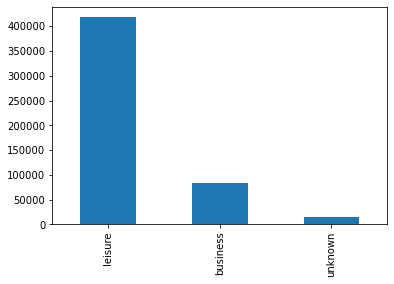

In [3]:
df.trip_type.value_counts().plot.bar()

<AxesSubplot:>

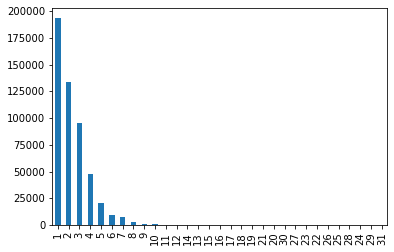

In [4]:
df.nights_stayed.value_counts().plot.bar()

<AxesSubplot:>

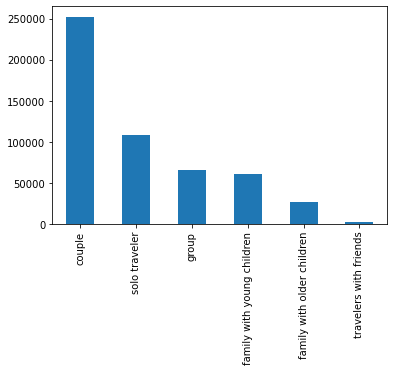

In [5]:
df.group_type.value_counts().plot.bar()

<AxesSubplot:ylabel='Frequency'>

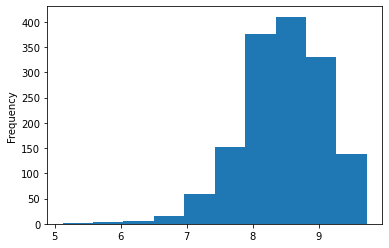

In [6]:
df.groupby(df.hotel_name).reviewer_score.mean().plot.hist()

### Exploration - Natural Language Processing

- Notes...

In [7]:
pos_reviews = ' '.join(df.positive_clean_review)
pos_reviews = pos_reviews.split()

neg_reviews = ' '.join(df.negative_clean_review) 
neg_reviews = neg_reviews.split()

<AxesSubplot:>

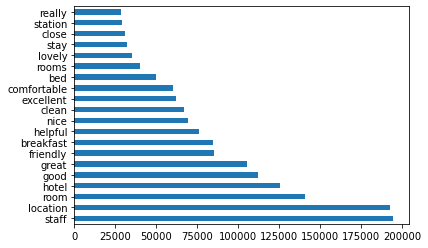

In [8]:
pd.Series(pos_reviews).value_counts().head(20).plot.barh()

<AxesSubplot:>

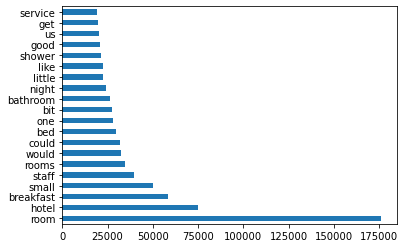

In [9]:
pd.Series(neg_reviews).value_counts().head(20).plot.barh()

In [10]:
#positive review bigrams
pos_bigrams = (pd.Series(nltk.ngrams(pos_reviews, 2)).value_counts().head(20))
pos_bigrams.head(20)

(great, location)        30992
(friendly, staff)        25238
(staff, friendly)        24828
(friendly, helpful)      21450
(good, location)         21091
(helpful, staff)         17820
(staff, helpful)         16788
(excellent, location)    12891
(location, great)        12811
(location, good)         11604
(location, staff)         9457
(breakfast, good)         9417
(good, breakfast)         9335
(comfortable, bed)        9006
(location, excellent)     8936
(staff, great)            8832
(room, clean)             8601
(walking, distance)       8406
(bed, comfortable)        7481
(helpful, friendly)       7368
dtype: int64

In [11]:
#negative review bigrams
neg_bigrams = (pd.Series(nltk.ngrams(neg_reviews, 2)).value_counts().head(20))
neg_bigrams.head(20)

(room, small)            9680
(room, service)          6330
(small, room)            6067
(air, conditioning)      5524
(booking, com)           4469
(star, hotel)            4000
(tea, coffee)            3948
(rooms, small)           3420
(4, star)                3234
(air, con)               3185
(breakfast, included)    3069
(even, though)           2972
(front, desk)            2914
(room, bit)              2827
(double, bed)            2821
(could, better)          2793
(little, bit)            2764
(bit, small)             2762
(would, nice)            2730
(mini, bar)              2723
dtype: int64

In [12]:
#positive review trigrams
pos_trigrams = (pd.Series(nltk.ngrams(pos_reviews, 3)).value_counts().head(20))
pos_trigrams.head(20)

(staff, friendly, helpful)     9667
(friendly, helpful, staff)     7191
(location, friendly, staff)    4081
(staff, helpful, friendly)     3189
(staff, great, location)       3170
(hotel, great, location)       2777
(good, value, money)           2553
(within, walking, distance)    2403
(friendly, staff, good)        2080
(would, definitely, stay)      2049
(staff, good, location)        2019
(friendly, staff, great)       2008
(helpful, friendly, staff)     1977
(staff, extremely, helpful)    1960
(great, location, friendly)    1760
(nothing, much, trouble)       1639
(hotel, good, location)        1561
(location, great, staff)       1524
(location, great, location)    1500
(location, staff, friendly)    1455
dtype: int64

In [13]:
#negative review trigrams
neg_trigrams = (pd.Series(nltk.ngrams(neg_reviews, 3)).value_counts().head(20))
neg_trigrams.head(20)

(4, star, hotel)                1915
(room, bit, small)              1171
(room, little, small)            907
(tea, coffee, making)            892
(5, star, hotel)                 874
(coffee, making, facilities)     873
(making, facilities, room)       769
(room, quite, small)             768
(tea, coffee, facilities)        655
(two, single, beds)              650
(breakfast, included, price)     596
(breakfast, could, better)       535
(4, stars, hotel)                507
(beds, pushed, together)         503
(front, desk, staff)             490
(four, star, hotel)              489
(tea, coffee, room)              485
(far, city, center)              475
(tea, making, facilities)        444
(air, conditioning, room)        442
dtype: int64

In [14]:
#positive review n-grams = 4
pos_quadgrams = (pd.Series(nltk.ngrams(pos_reviews, 4)).value_counts().head(20))
pos_quadgrams.head(20)

(great, location, friendly, staff)        1187
(location, friendly, helpful, staff)      1069
(friendly, staff, great, location)        1037
(staff, friendly, helpful, room)           830
(staff, friendly, helpful, location)       812
(friendly, staff, good, location)          745
(good, location, friendly, staff)          711
(helpful, staff, great, location)          683
(staff, extremely, friendly, helpful)      603
(location, staff, friendly, helpful)       568
(friendly, helpful, staff, great)          567
(friendly, helpful, staff, good)           541
(excellent, location, friendly, staff)     538
(hotel, staff, friendly, helpful)          508
(staff, really, friendly, helpful)         486
(staff, friendly, helpful, breakfast)      466
(friendly, helpful, staff, location)       444
(helpful, staff, good, location)           426
(friendly, staff, excellent, location)     425
(staff, friendly, helpful, hotel)          417
dtype: int64

In [15]:
#negative review n-grams = 4
neg_quadgrams = (pd.Series(nltk.ngrams(neg_reviews, 4)).value_counts().head(20))
neg_quadgrams.head(20)

(tea, coffee, making, facilities)     728
(coffee, making, facilities, room)    519
(tea, coffee, facilities, room)       370
(single, beds, pushed, together)      318
(tea, making, facilities, room)       218
(two, single, beds, pushed)           183
(room, little, bit, small)            171
(two, singles, pushed, together)      155
(bit, far, city, center)              124
(coffee, tea, making, facilities)     115
(breakfast, included, room, rate)     112
(2, single, beds, pushed)             109
(walls, thin, could, hear)            109
(room, little, small, side)           105
(room, two, single, beds)             102
(expect, 4, star, hotel)              100
(far, away, city, center)              88
(bit, far, city, centre)               87
(4, star, hotel, room)                 87
(tea, coffee, making, facility)        87
dtype: int64

In [16]:
#positive review n-grams = 5
pos_pentagrams = (pd.Series(nltk.ngrams(pos_reviews, 5)).value_counts().head(20))
pos_pentagrams.head(20)

(great, location, friendly, helpful, staff)        319
(friendly, helpful, staff, great, location)        299
(staff, friendly, helpful, great, location)        212
(staff, friendly, helpful, room, clean)            178
(friendly, helpful, staff, good, location)         177
(excellent, location, friendly, helpful, staff)    165
(good, location, friendly, helpful, staff)         151
(great, location, staff, friendly, helpful)        125
(staff, friendly, helpful, good, location)         119
(staff, friendly, helpful, breakfast, good)        114
(staff, friendly, helpful, location, great)        113
(friendly, helpful, staff, good, breakfast)        113
(location, great, staff, friendly, helpful)        103
(great, location, within, walking, distance)       100
(friendly, helpful, staff, excellent, location)     99
(great, location, friendly, staff, good)            96
(staff, friendly, helpful, location, excellent)     90
(great, location, friendly, staff, clean)           85
(location,

In [17]:
#negative review n-grams = 5
neg_pentagrams = (pd.Series(nltk.ngrams(neg_reviews, 5)).value_counts().head(20))
neg_pentagrams.head(20)

(tea, coffee, making, facilities, room)     436
(two, single, beds, pushed, together)       179
(2, single, beds, pushed, together)         108
(bed, two, singles, pushed, together)        74
(two, single, beds, put, together)           57
(coffee, tea, making, facilities, room)      56
(tea, coffee, making, facility, room)        53
(double, bed, two, single, beds)             51
(double, bed, two, singles, pushed)          42
(would, expect, 4, star, hotel)              39
(room, two, single, beds, pushed)            37
(would, liked, tea, coffee, making)          37
(bed, 2, singles, pushed, together)          34
(room, tea, coffee, making, facilities)      33
(liked, tea, coffee, making, facilities)     30
(tea, coffee, making, facilities, rooms)     30
(could, hear, people, next, door)            28
(two, twin, beds, pushed, together)          28
(location, bit, far, city, center)           28
(could, hear, people, next, room)            25
dtype: int64

# Sentiment Intensity Analysis

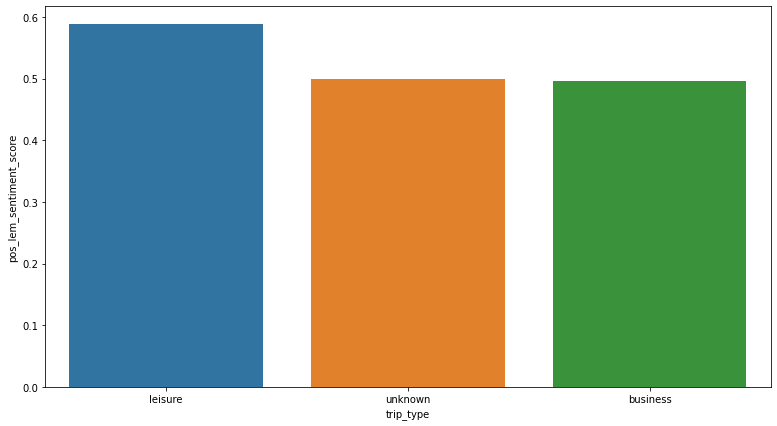

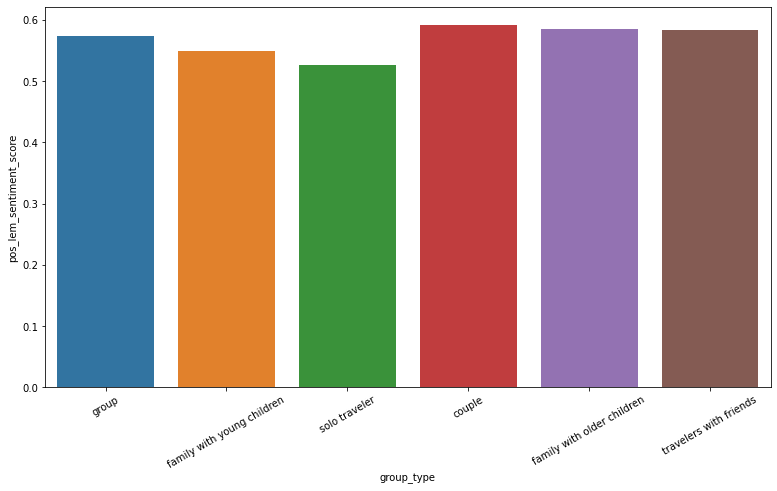

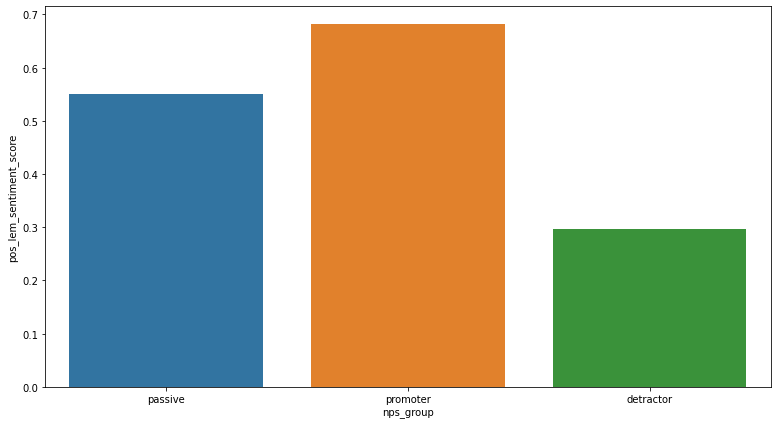

<AxesSubplot:xlabel='nps_group', ylabel='neg_lem_sentiment_score'>

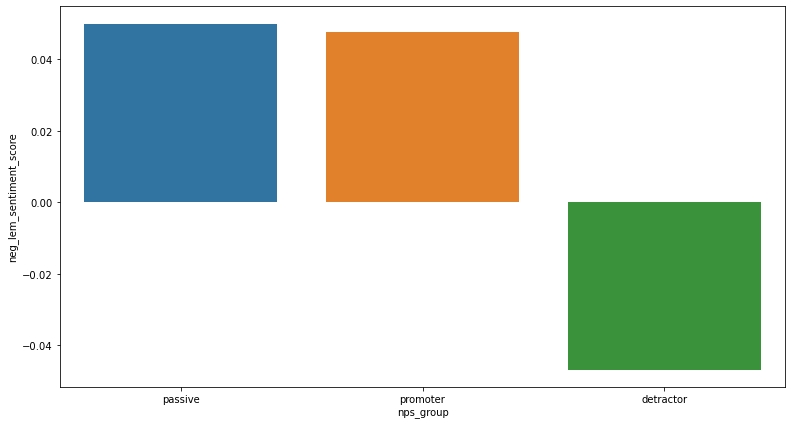

In [18]:
#Compare trip type and positive sentiment score
plt.figure(figsize=(13,7))
sns.barplot(data=df, x= 'trip_type', y= 'pos_lem_sentiment_score', ci=False)
plt.show()

#Compare group type and positive sentiment score
plt.figure(figsize=(13,7))
sns.barplot(data=df, x= 'group_type', y= 'pos_lem_sentiment_score', ci=False)
plt.xticks(rotation=30)
plt.show()

#Compare NPS group and positive sentiment score
plt.figure(figsize=(13,7))
sns.barplot(data=df, x='nps_group', y='pos_lem_sentiment_score', ci=False)
plt.show()

#Compare NPS group and negative sentiment score
plt.figure(figsize=(13,7))
sns.barplot(data=df, x='nps_group', y='neg_lem_sentiment_score', ci=False)




# Topic Modeling ?? visualize ??

---

### Net Promoter Scores (NPS):

- Notes...

In [19]:
def hotel_nps_score(series):
    score = ((series == 'promoter').sum() - (series == 'detractor').sum()) / series.size
    score = round(score * 100)
    return score

In [20]:
hotel_df = pd.DataFrame(df.groupby(df.hotel_name).nps_group.apply(hotel_nps_score))
hotel_df.sort_values(by='nps_group', ascending=False)

,nps_group
hotel_name,
H10 Casa Mimosa 4 Sup,93
Ritz Paris,93
Hotel Casa Camper,93
The Soho Hotel,92
Bulgari Hotel London,92
...,...
Villa Eugenie,-52
Kube Hotel Ice Bar,-53
Savoy Hotel Amsterdam,-56
